# Using Word2Vec Embedding to extend POC Guesser

We can use Gensim to make a more powerful version of our Proof-of-Concept. The main limitation will be guesses that lie outside of the training corpora; we might tackle this later with FastText. For now, let's see if we can make less of a toy version using the Google News Skip-Gram model with 300-feature embeddings (requires ~2GB).

Make sure to update SSL Certificate to download if required: 
```
pip install -U certifi

/Applications/Python 3.X/Install Certificates.command
```

In [1]:
import os
import gensim
import gensim.downloader
import gensim.models

saved_path_name = "word2vec-google-news-300_c"
limit = 200_000

if not os.path.exists(saved_path_name):
    print("Checking cache and downloading")
    google_news_wv = gensim.downloader.load("word2vec-google-news-300")
    google_news_wv.save_word2vec_format(saved_path_name)
    print("Saved to disk in C format")
    del google_news_wv

print(f"Loading {limit} from saved")
google_news_wv = gensim.models.KeyedVectors.load_word2vec_format(saved_path_name, limit=limit)

Loading 200000 from saved


In [2]:
print(len(google_news_wv.index_to_key))
for index, word in enumerate(google_news_wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(google_news_wv.index_to_key)} is {word}")

200000
word #0/200000 is </s>
word #1/200000 is in
word #2/200000 is for
word #3/200000 is that
word #4/200000 is is
word #5/200000 is on
word #6/200000 is ##
word #7/200000 is The
word #8/200000 is with
word #9/200000 is said


Let's see if the model has each of our official words

In [3]:
import decryptogame as dg

for word in dg.official_words.english.words:
    if word.lower() not in google_news_wv:
        print(word)

SCIENCE-FICTION
FRANCE
CYCLOPS
EGYPT
EXTRA-TERRESTRIAL
CALENDA
GERMANY
QUEBEC
PEGASUS
ARMOUR
CENTAUR
AFRICA
RUSSIA
SLAUGHTER-HOUSE
THEATRE
MOUSTACHE


I suspect this may just be a matter of capitalization, formatting, and British spellings. Let's see if we can make a mapping; if not we can use the weak linearity of Word2Vec. 

In [4]:
def official_keyword_to_word(keyword: str):
    typos = { "CALENDA": "calendar"}
    if keyword in typos:
        return typos[keyword]
    proper_nouns = [
        "AFRICA",
        "CENTAUR",
        "CYCLOPS",
        "EGYPT",
        "FRANCE",
        "GERMANY",
        "PEGASUS",
        "QUEBEC",
        "RUSSIA"
    ]
    if keyword in proper_nouns:
        return keyword.capitalize()
    british = {
        "ARMOUR": "armor",
        "MOUSTACHE": "mustache",
        "THEATRE": "theater",
    }
    if keyword in british:
        return british[keyword]
    if '-' in keyword:
        if keyword == "SCIENCE-FICTION":
            keyword = keyword.replace('-', '_')
        keyword = keyword.replace('-', '')
    return keyword.lower()

if any(official_keyword_to_word(keyword) not in google_news_wv for keyword in dg.official_words.english.words):
    print("Gonna have to improvise")
print("Done!")





Done!


Looks like we don't need to improvise! Let's see what the keywords the creators chose look like using t-SNE

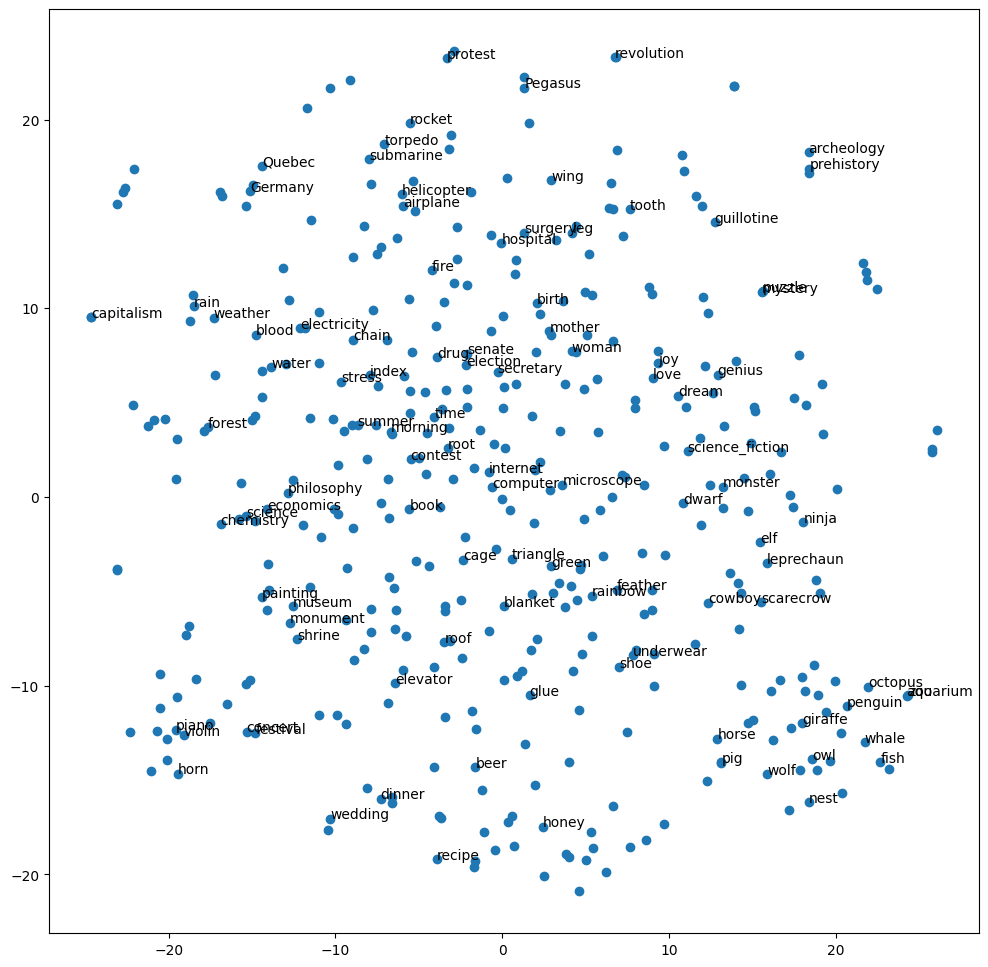

In [16]:
# inspired by https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

words = [official_keyword_to_word(word) for word in dg.official_words.english.words]
vectors = np.asarray([google_news_wv[word] for word in words])

# reduce using t-SNE
num_dimensions = 2
tsne = TSNE(n_components=num_dimensions, random_state=0)
vectors = tsne.fit_transform(vectors)
x_vals, y_vals, *_ = zip(*vectors) # x has v[0] for each vector, y has v[1]

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels, num_show=100):
    import matplotlib.pyplot as plt
    import random

    random.seed(400)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, num_show)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot_function = plot_with_matplotlib
plot_function(x_vals, y_vals, words)